In [1]:
%load_ext autoreload
%autoreload 2

# Inference with InfGCN

By Chaoran Cheng, Oct 1, 2023


In [2]:
import os

import torch
import lz4.frame
from tqdm import tqdm
import plotly.graph_objects as go
from IPython.display import Image, display

from datasets import DensityDataset
from models import get_model
from utils import load_config

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda')

In [3]:
# Set to True to generate static figures
# Set to False to generate interactive figures
# WARNING: Interactive figures significantly increase the notebook size
static_fig = True

In [4]:
def get_pretrained_model(cfg_path, model_path):
    print(f'Loading config from {cfg_path}')
    cfg = load_config(cfg_path)
    model = get_model(cfg.model).to(device)
    print(f'Loading model from {model_path}')
    ckpt = torch.load(model_path, map_location=device)
    model.load_state_dict(ckpt['model'])
    return model

In [5]:
def inference_model(model, g, density, grid_coord, infos, grid_batch_size=8196):
    with torch.no_grad():
        model.eval()
        if grid_batch_size is None:
            preds = model(g.x, g.pos, grid_coord, g.batch, infos).squeeze(0)
        else:
            preds = []
            for grid in tqdm(grid_coord.split(grid_batch_size, dim=1)):
                preds.append(model(g.x, g.pos, grid.contiguous(), g.batch, infos).squeeze(0))
            preds = torch.cat(preds, dim=0)
        diff = torch.abs(preds - density)
        loss = diff.pow(2).sum()
        mae = diff.sum() / density.sum()
    return preds, loss, mae

In [6]:
def draw_volume(grid, density, atom_type, atom_coord, isomin=0.05, isomax=None, surface_count=5, title=None):
    atom_colorscale = ['grey', 'white', 'red', 'blue', 'green']
    fig = go.Figure()
    fig.add_trace(go.Volume(
        x=grid[..., 0], y=grid[..., 1], z=grid[..., 2],
        value=density,
        isomin=isomin,
        isomax=isomax,
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=surface_count, # needs to be a large number for good volume rendering
        caps=dict(x_show=False, y_show=False, z_show=False),
    ))
    axis_dict = dict(
        showgrid=False,
        showbackground=False,
        zeroline=False,
        visible=False,
    )
    fig.add_trace(go.Scatter3d(
        x=atom_coord[:, 0],
        y=atom_coord[:, 1],
        z=atom_coord[:, 2],
        mode='markers',
        marker=dict(
            size=10,
            color=atom_type,   
            cmin=0, cmax=4,
            colorscale=atom_colorscale,
            opacity=0.6
        )
    ))
    if title is not None:
        title = dict(
            text=title,
            x=0.5, y=0.3,
            xanchor='center',
            yanchor='bottom',
        )
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        showlegend=False,
        scene=dict(
            xaxis=axis_dict,
            yaxis=axis_dict,
            zaxis=axis_dict
        ),
        title=title,
        title_font_family='Times New Roman',
    )
    return fig

In [7]:
# Load the dataset
# If you want to run the pretrained model, you can make a dummy data split file like
# {"train": [], "val": [], "test": []}
dataset = DensityDataset('data/QM9', 'test', 'data_split.json', './atom_info/qm9.json', 'CHGCAR', 'lz4')

In [8]:
file_id = 24492  # indole
# file_id = 114514  # nonane
# file_id = 214  # benzene
# file_id = 2  # ammonia
with lz4.frame.open(f'data/QM9/{file_id:06d}.CHGCAR.lz4') as f:
    g, density, grid_coord, info = dataset.read_chgcar(f)

g.batch = torch.zeros_like(g.x)
g = g.to(device)
density = density.to(device)
grid_coord = grid_coord.to(device)

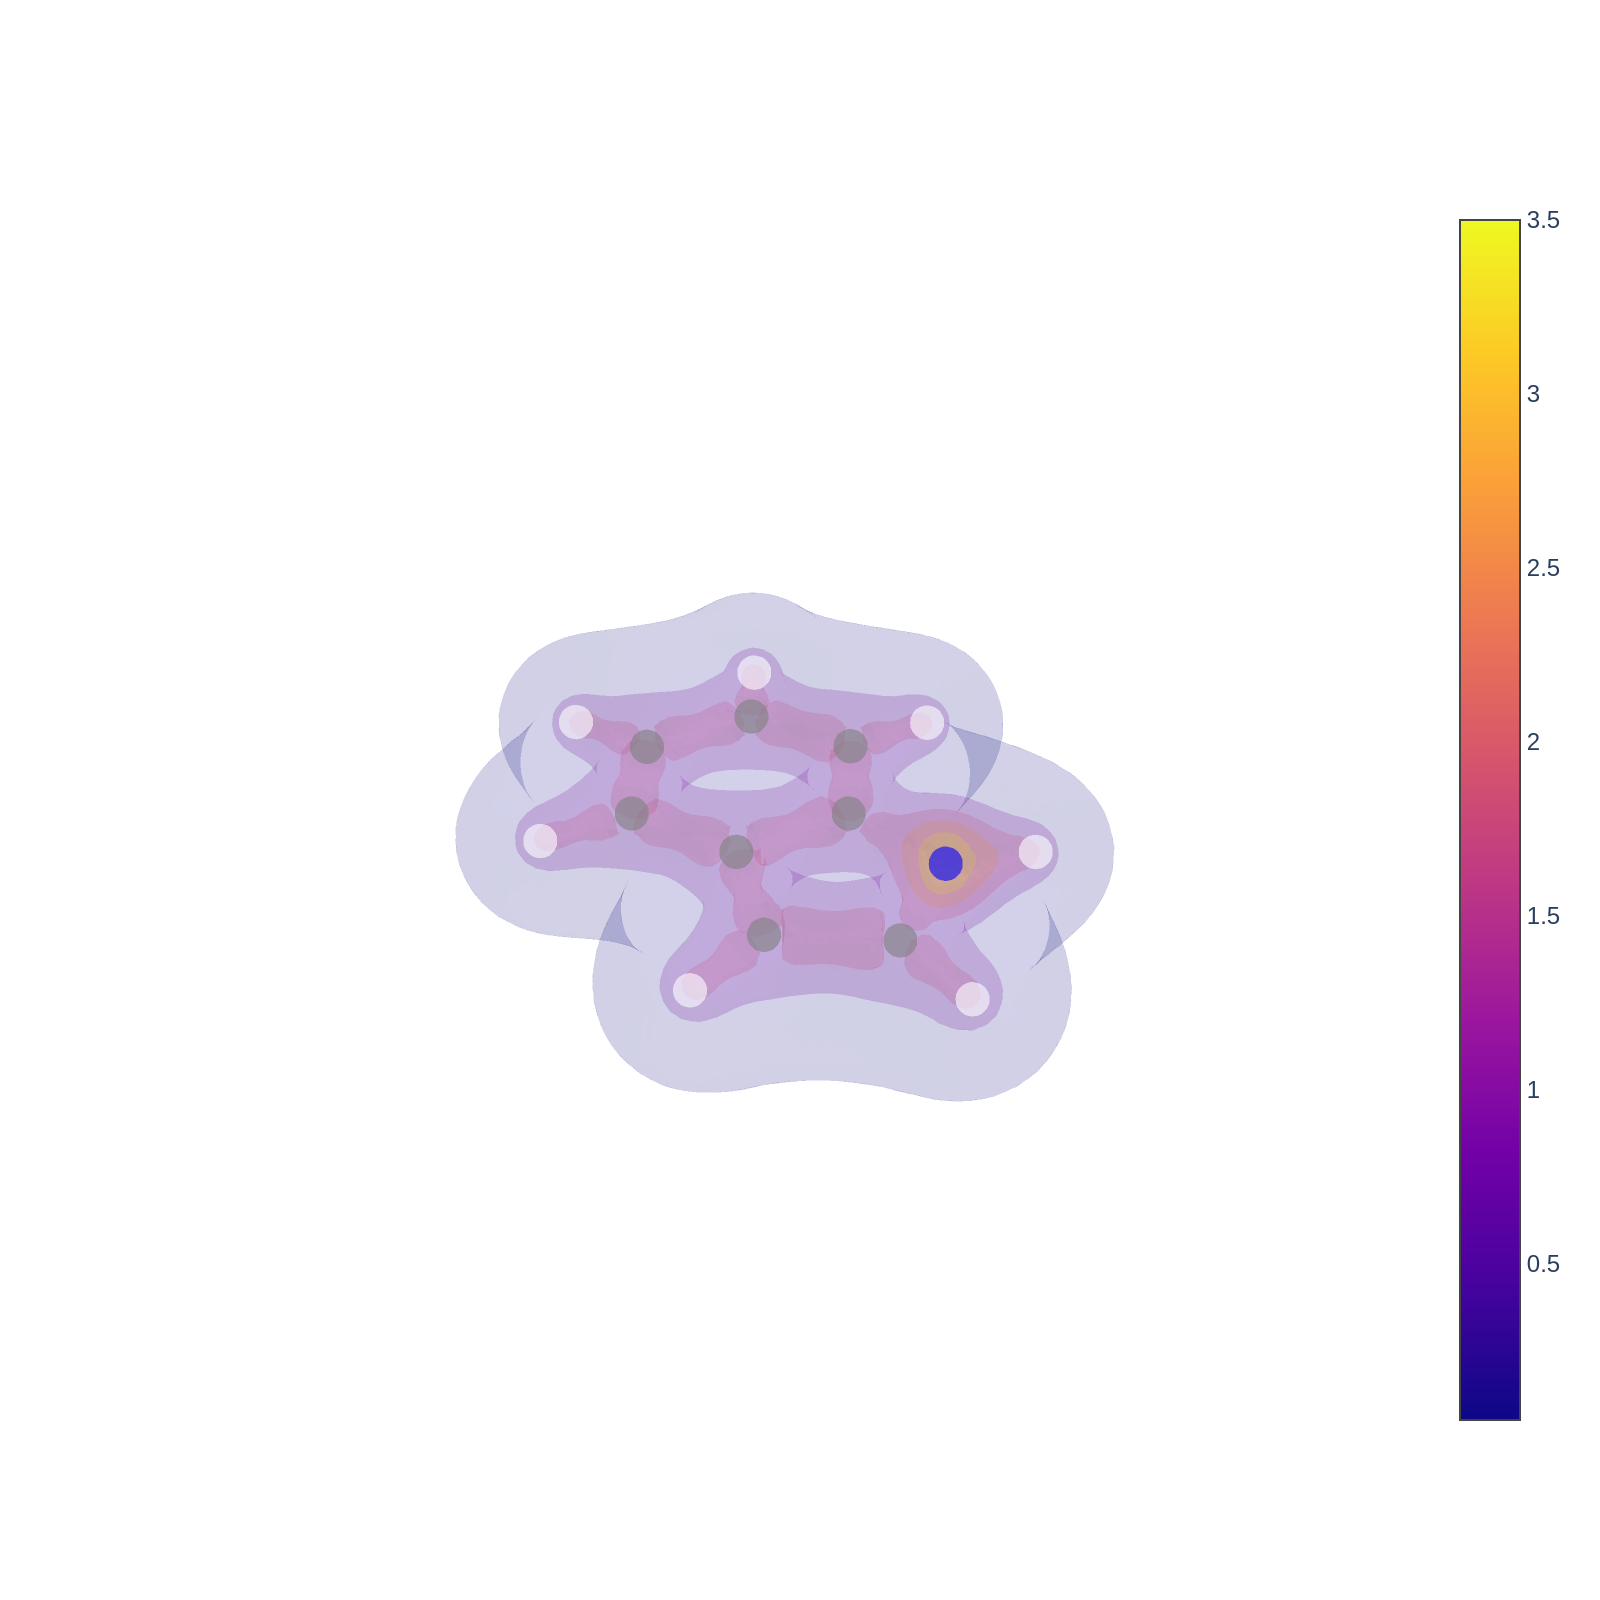

In [9]:
# Display the ground truth electron density
fig = draw_volume(
    grid_coord.detach().cpu().numpy(), density.detach().cpu().numpy(),
    g.x.detach().cpu().numpy(), g.pos.detach().cpu().numpy(),
    isomin=0.05, isomax=3.5, surface_count=5
)
if static_fig:
    img_bytes = fig.to_image(format="png", scale=2)
    display(Image(img_bytes))
else:
    fig.show()

In [10]:
# Load the pretrained model
# There might be a warning from jitting, which arises inside the `e3nn` package.
# You can safely ignore it.
model = get_pretrained_model('configs/qm9.yml', 'logs/train/40000.pt')
print('Complete!')

Loading config from configs/qm9.yml


Loading model from logs/train/40000.pt


In [11]:
# Make prediction
# The very first step might be slow (due to jitting in `e3nn`), but the rest should be fast.
grid_batch_size = 4096
preds, loss, mae = inference_model(
    model, g, density, grid_coord[None], [info], grid_batch_size=grid_batch_size
)
print(f'Loss: {loss.item():.6f}, MAE: {mae.item():.6f}')

100%|██████████████████████████████████████████████████████████████████████████| 51/51 [00:55<00:00,  1.08s/it]

Loss: 5.442680, MAE: 0.014575


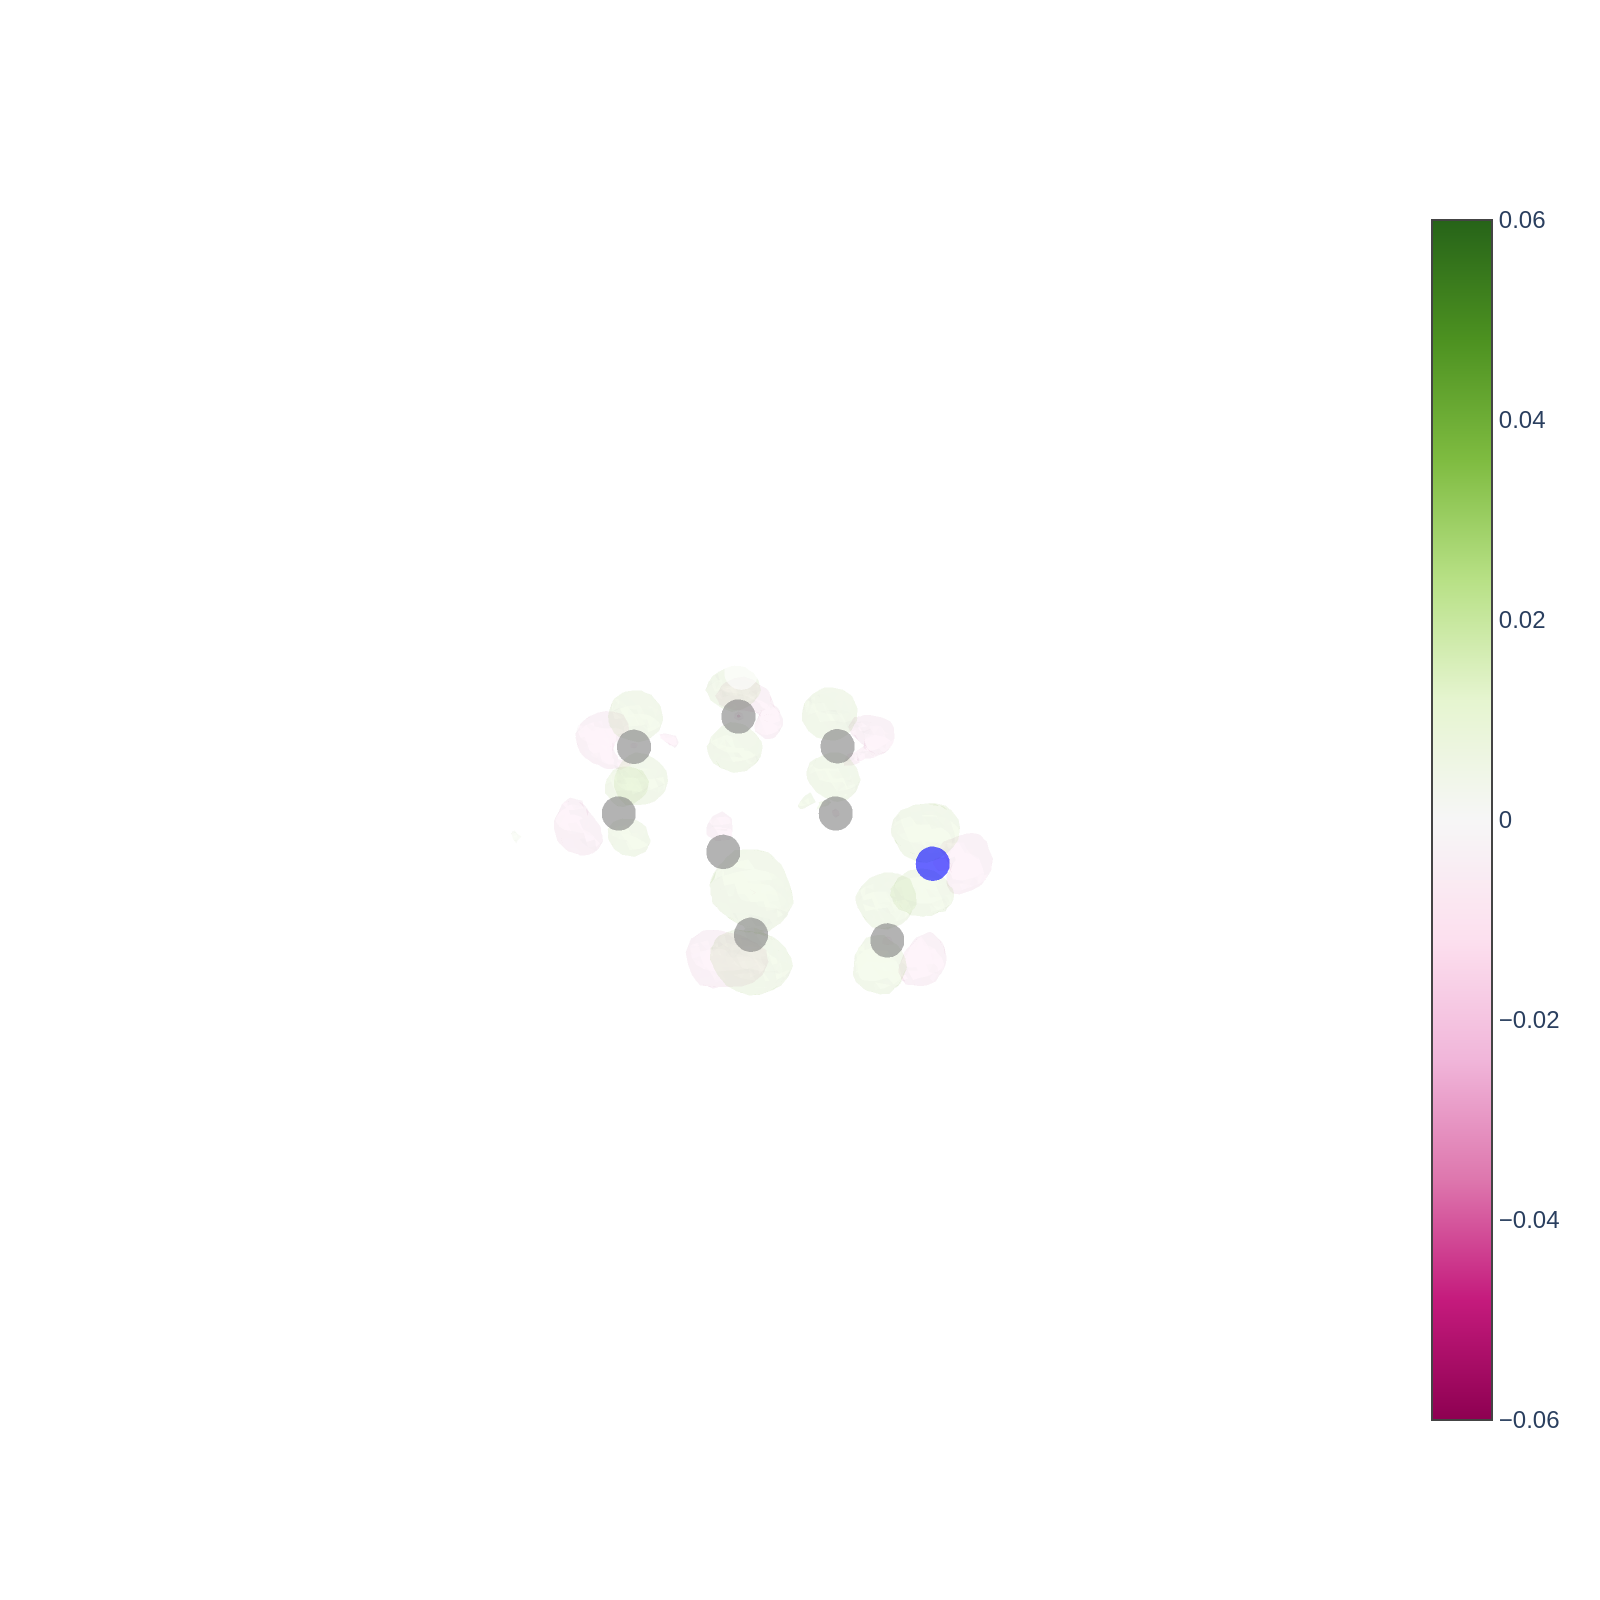

In [12]:
# Display the electron density difference
fig = draw_volume(
    grid_coord.detach().cpu().numpy(), (density - preds).detach().cpu().numpy(),
    g.x.detach().cpu().numpy(), g.pos.detach().cpu().numpy(), isomin=-0.06, isomax=0.06, surface_count=4
)
if static_fig:
    img_bytes = fig.to_image(format="png", scale=2)
    display(Image(img_bytes))
else:
    fig.show()

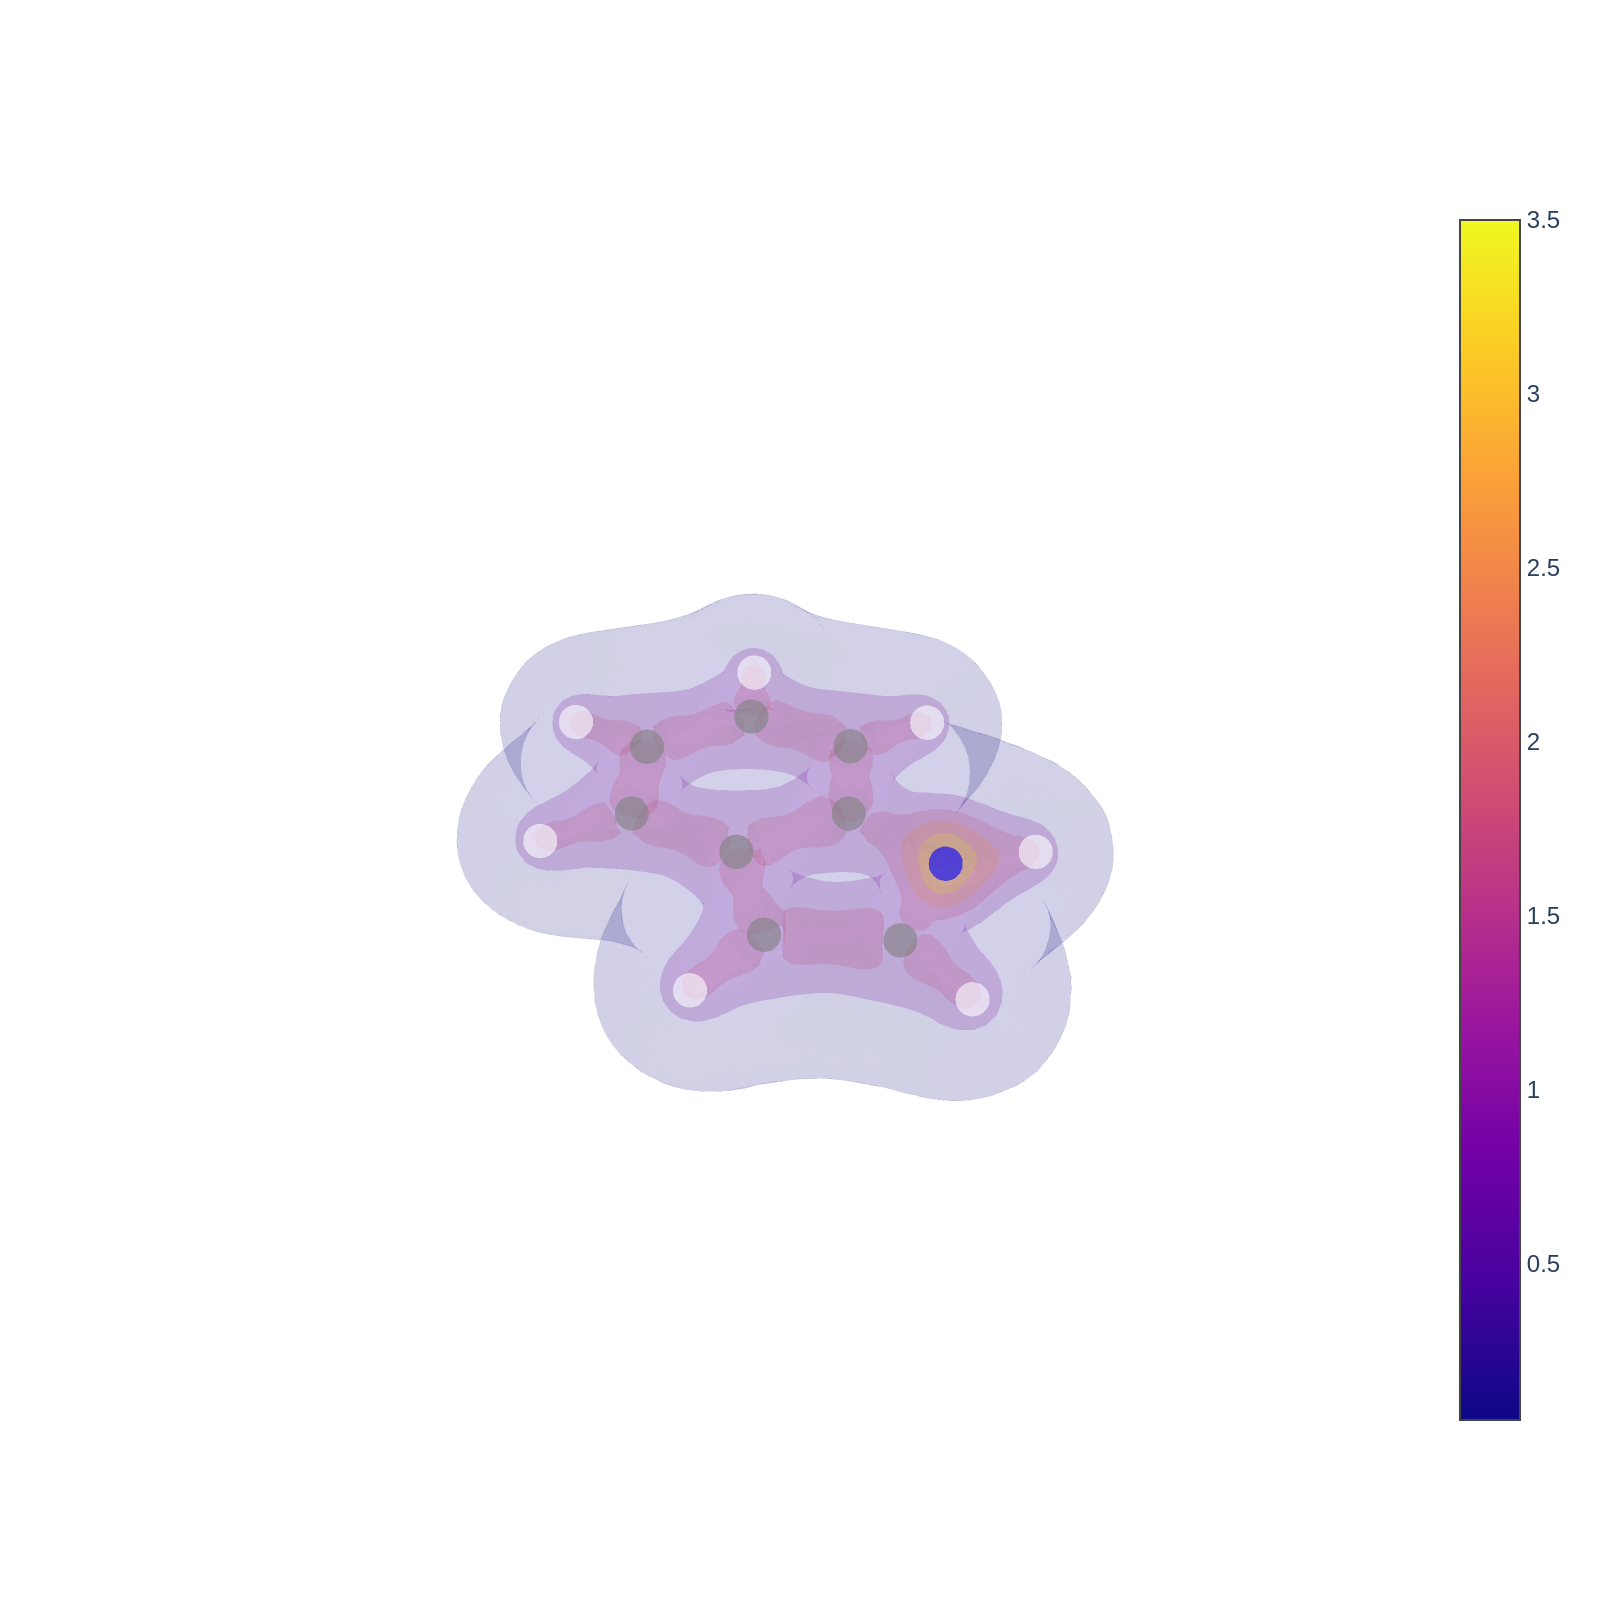

In [13]:
# Display the predicted electron density
fig = draw_volume(
    grid_coord.detach().cpu().numpy(), preds.detach().cpu().numpy(),
    g.x.detach().cpu().numpy(), g.pos.detach().cpu().numpy(), isomin=0.05, isomax=3.5, surface_count=5
)
if static_fig:
    img_bytes = fig.to_image(format="png", scale=2)
    display(Image(img_bytes))
else:
    fig.show()